# Соревнование: San Francisco Crime Classification

_Given time and location, you must predict the category of crime that occurred. Kaggle is hosting this competition for the machine learning community to use for fun and practice._

https://www.kaggle.com/c/sf-crime

## 1. Подготовка работы. Загрузка библиотек и настройка отображения
Импорты и настроийки, которые необходимы для шаблона.

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime

%matplotlib inline

## 2. Загрузка, очистка данных. Exploratory data analysis.

Загрузка тренировочных данных из csv:

In [73]:
train_data = pd.read_csv('data/train.csv')

Просмотрим структуру данных:

In [74]:
train_data.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


Целевая переменная находится в столбце *Category*, ее и надо будет предсказать.

In [75]:
train_data[['Category', 'Descript','DayOfWeek','PdDistrict','Resolution','Address']].describe()

,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address
count,878049,878049,878049,878049,878049,878049
unique,39,879,7,10,17,23228
top,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,SOUTHERN,NONE,800 Block of BRYANT ST
freq,174900,60022,133734,157182,526790,26533


In [76]:
train_data[['X','Y']].describe()

,X,Y
count,878049.000000,878049.000000
mean,-122.422616,37.771020
std,0.030354,0.456893
min,-122.513642,37.707879
25%,-122.432952,37.752427
50%,-122.416420,37.775421
75%,-122.406959,37.784369
max,-120.500000,90.000000


Видно, что есть преступления со странными координатами -120, 90 возможно эти данные были занесены с ошибками. Посчитаем сколько у нас таких данных.

In [77]:
train_data[(train_data['X']==-120.5) & (train_data['Y']==90.0)].shape[0]

67

Всего таких записей 67, поэтому чтобы не портить нам регрессию, просто удалим эти строки.

In [78]:
train_data = train_data[(train_data['X']!=-120.5) | (train_data['Y']!=90.0)]

Немного преобразуем данные, конвертируем строку дата в DateTime объект, а другие столбцы конвертируем в категориальные переменные.

In [79]:
train_data.Dates = pd.to_datetime(train_data.Dates)
train_data.Category = train_data.Category.astype('category')
train_data.Descript = train_data.Descript.astype('category')
train_data.DayOfWeek = train_data.DayOfWeek.astype('category')
train_data.PdDistrict = train_data.PdDistrict.astype('category')
train_data.Resolution = train_data.Resolution.astype('category')
train_data.Address = train_data.Address.astype('category')

Построим гистограмму самых распространненых преступлений:

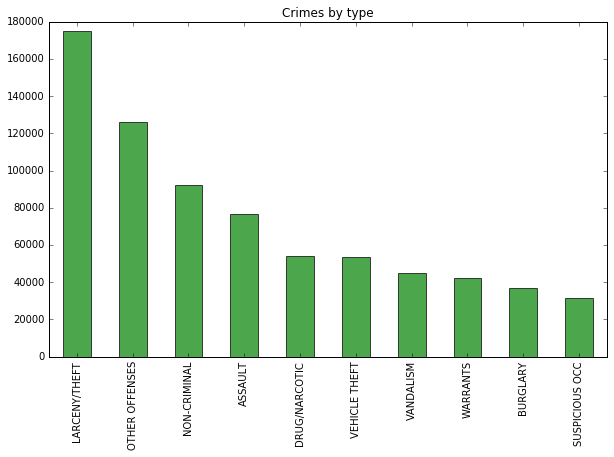

In [80]:
plt.figure(figsize=(10, 6))
train_data.Category.value_counts()[:10].plot(kind='bar', title='Crimes by type', color='green', alpha=0.7)
plt.show()

Остальные преступления:

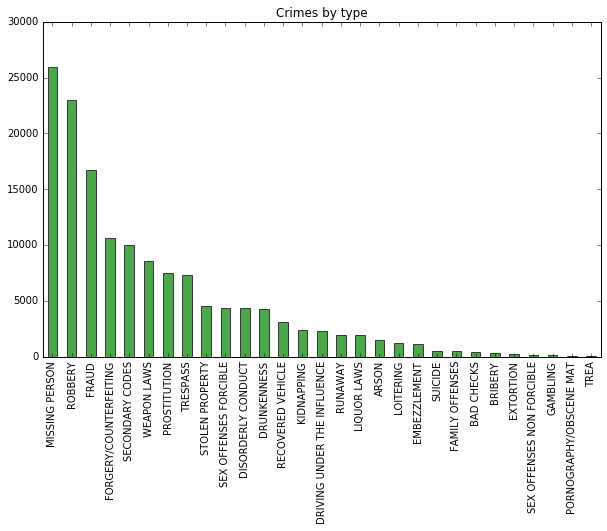

In [81]:
plt.figure(figsize=(10, 6))
train_data.Category.value_counts()[10:].plot(kind='bar', title='Crimes by type', color='green', alpha=0.7)
plt.show()

Разобьем нашу дату на час, день месяца, месяц и год, чтобы получить больше информации:

In [82]:
def convert_time(data):
    data['Hour'] = data.Dates.apply(lambda x: x.hour)
    data['Day'] = data.Dates.apply(lambda x: x.day)
    data['Month'] = data.Dates.apply(lambda x: x.month)
    data['Year'] = data.Dates.apply(lambda x: x.year)
    return data
train_data = convert_time(train_data)

Построим график зависимости количества преступлений от часа дня, дня месяца, дня недели, месяца и года:

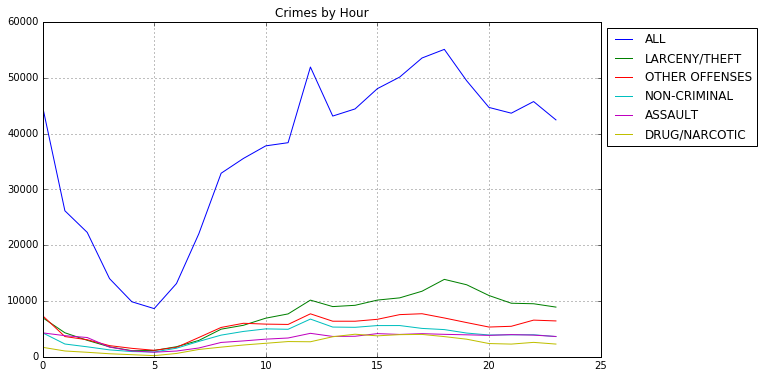

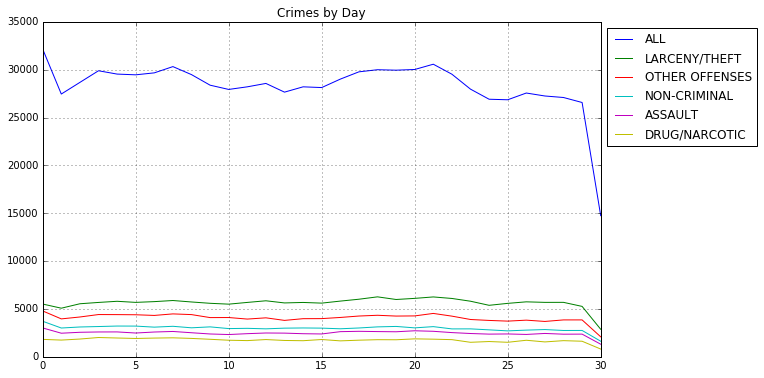

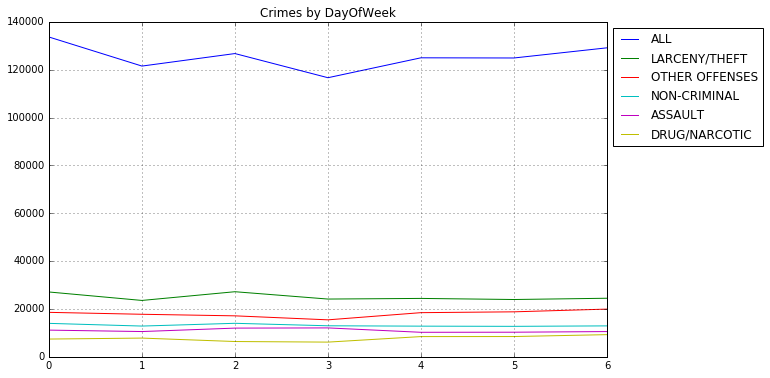

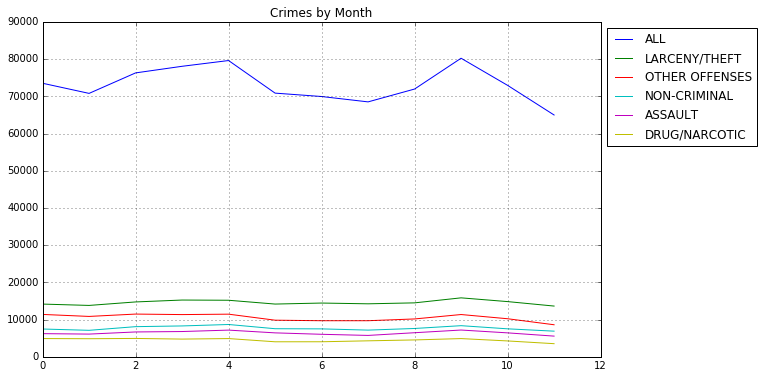

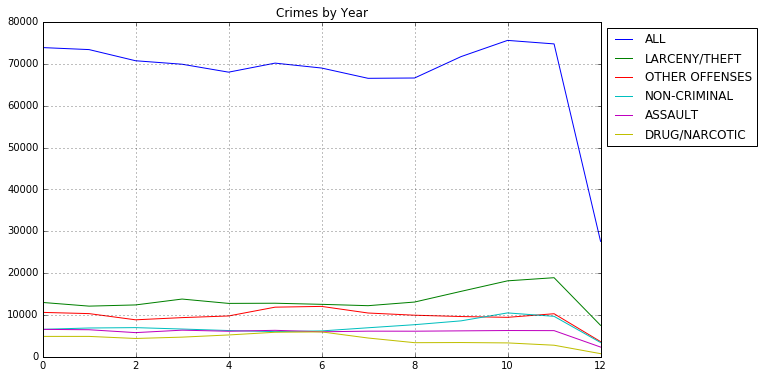

In [83]:
def plot_by_param(param):
    plt.figure(figsize=(10, 6))
    top5_categories = train_data.Category.value_counts().index[:5].tolist()
    plt.plot(train_data[param].value_counts().sort_index().tolist(), label='ALL')
    for cat in top5_categories:
        plt.plot(train_data[train_data.Category==cat][param].value_counts().sort_index().tolist(), label=cat)
    plt.legend(bbox_to_anchor=(1, 1), loc=2,)
    plt.title('Crimes by %s' % (param))
    plt.grid(True)
    
params = ['Hour','Day','DayOfWeek','Month','Year']
for param in params:
    plot_by_param(param)

Видно, что больше всего выражена зависимость числа преступлений от часа суток. Так же есть слабая зависимость некоторых преступлений от дня недели и от года.

Построим теперь карту преступлений:

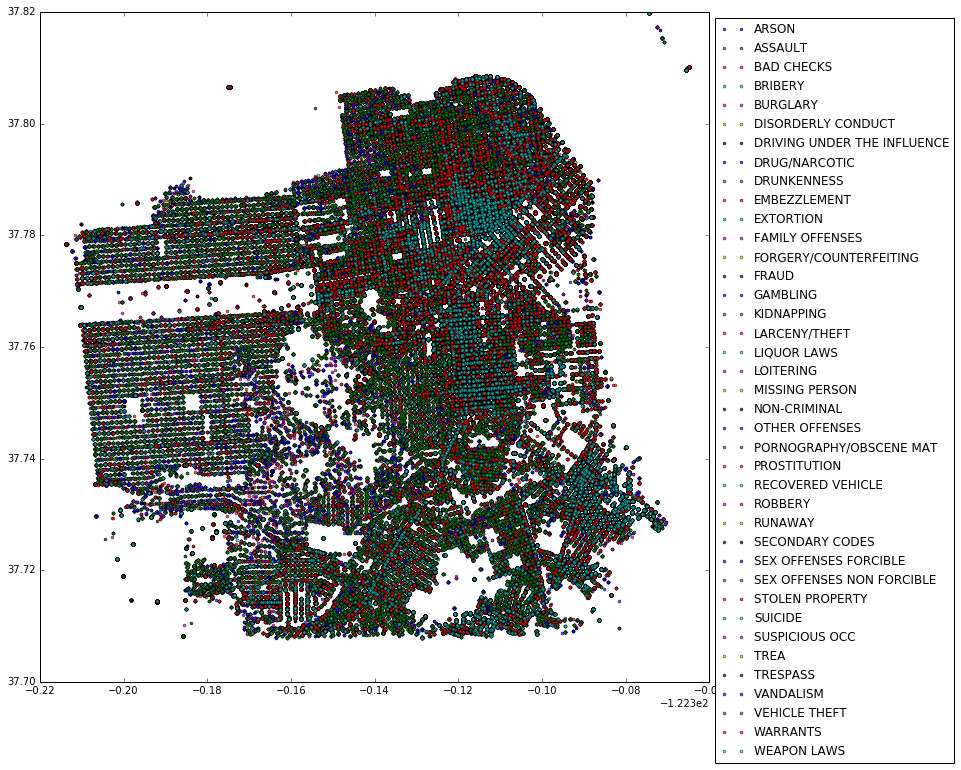

In [84]:
fig, ax = plt.subplots(figsize=(12, 12))
for cat in train_data.Category.cat.categories:
    ax.plot(train_data[train_data.Category==cat].X, train_data[train_data.Category==cat].Y, 
            marker='o', linestyle='', ms=3, alpha=0.7, label = cat)
ax.legend(bbox_to_anchor=(1, 1), loc=2,)

Попробуем построить такую же карту, но возьмем только первые 5 самые популярные виды преступлений:

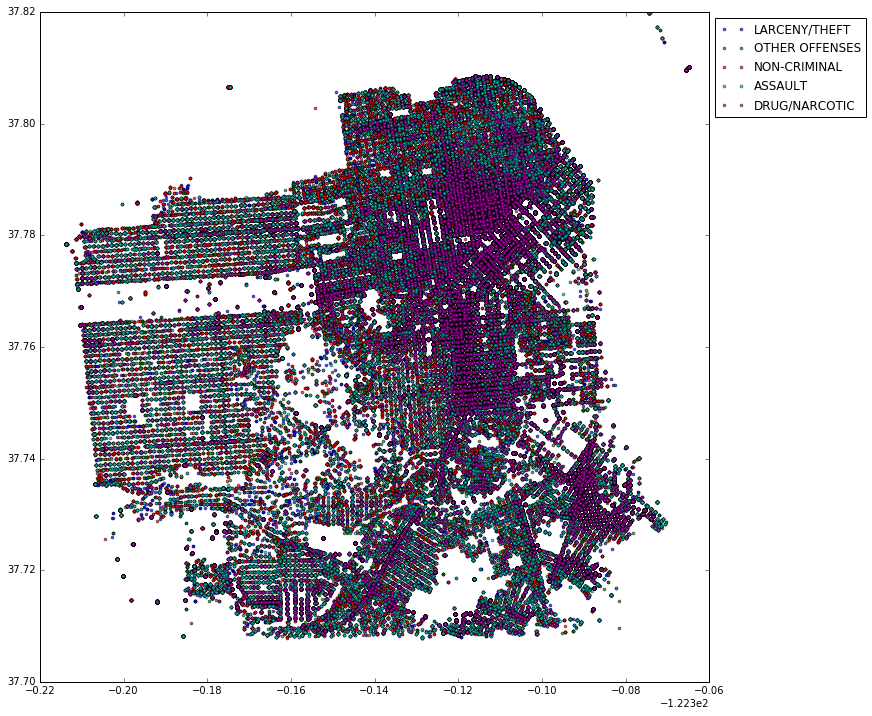

In [85]:
fig, ax = plt.subplots(figsize=(12, 12))
for cat in train_data.Category.value_counts().index[:5].tolist():
    ax.plot(train_data[train_data.Category==cat].X, train_data[train_data.Category==cat].Y, 
            marker='o', linestyle='', ms=3, alpha=0.7, label = cat)
ax.legend(bbox_to_anchor=(1, 1), loc=2,)

Видно, что некоторые преступления сгруппированы в большие кучи, это можно будет использовать.

Построим тепловую карту преступлений:

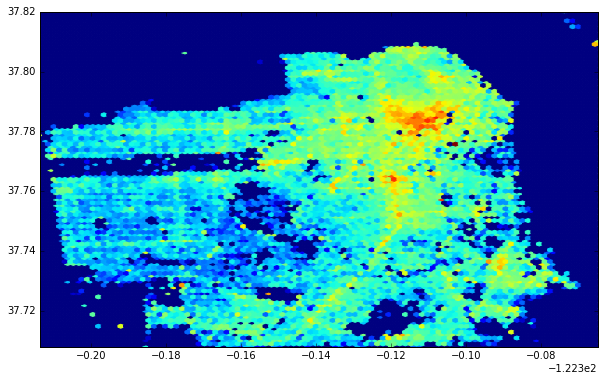

In [86]:
plt.figure(figsize=(10, 6))
plt.hexbin(train_data.X, train_data.Y, bins='log')

Видно, что больше всего преступлений в центре, но пока не особо понятно, как это знание поможет нам определять тип преступления.

## 3. Построение дополнительных признаков.

Напишем дополнительные функции, чтобы преобразовать наши данные.

In [87]:
from sklearn import preprocessing

In [88]:
fiature_converters = dict()

def feature_binarizer(data, feature_name, fit=False):
    if(fit):
        fiature_converters[feature_name]=preprocessing.LabelBinarizer()
        #fiature_converters[feature_name]=preprocessing.OneHotEncoder()
        fiature_converters[feature_name].fit(data[feature_name].values)
    return fiature_converters[feature_name].transform(data[feature_name].values)

def conv_street(street):
    if street.find('/') != -1:
        return map(str.strip, street.split('/'))    
    pos = street.find('Block of ')
    if pos != -1:        
        return [street[pos+9:]]    
    return [street]

def build_streets(data):
    streets = set()
    for x in data.Address[0:10]:
        streets |= set(conv_street(x))
    return streets

def append_streets(adr_column, streets):
    streets_cols = np.zeros((len(adr_column),len(streets)), dtype=int)
    for i, street in enumerate(streets):
        for j, address in enumerate(adr_column):
            if address.find(street) != -1:
                streets_cols[j,i] = 1
    return streets_cols

streets = build_streets(train_data)

coords_scaler = preprocessing.MinMaxScaler()
def transform_coords(data,fit=False):
    if fit:
        coords_scaler.fit(data)
    return coords_scaler.transform(data)

category_enc = None
def conv_category(data, fit=False):
    if fit:
        category_enc = preprocessing.LabelEncoder()
        category_enc.fit(data)
    return category_enc.transform(data)

In [89]:
X_train = np.hstack((transform_coords(train_data[['X', 'Y']].values,True),
                     feature_binarizer(train_data,'Hour',True),
                     feature_binarizer(train_data,'Day',True),
                     feature_binarizer(train_data,'Month',True),
                     feature_binarizer(train_data,'Year',True),
                     feature_binarizer(train_data,'DayOfWeek',True),
                     #feature_binarizer(train_data,'Address',True),
                     append_streets(train_data.Address, streets),
                     feature_binarizer(train_data,'PdDistrict',True)))

In [90]:
y_train = conv_category(train_data.Category.values, True)

## 4. Обучение

In [106]:
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import log_loss

def cross_evaluate_model(clf,X_train,y_train):
    start_time = datetime.datetime.now()
    scores = cross_val_score(clf, X_train, y_train, cv=5,scoring='log_loss')
    duration = (datetime.datetime.now() - start_time).total_seconds()

    print('Classifier: {0}'.format(type(clf)))
    print 'Time elapsed:', duration
    print 'average score (5 folds): %s' % scores.mean()
    
def evaluate_model(clf,X,y,test_size=0.8):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42)
    
    start_time = datetime.datetime.now()
    clf.fit(X_train,y_train)
    fit_duration = (datetime.datetime.now() - start_time).total_seconds()
    
    start_time = datetime.datetime.now()
    y_pred_train = clf.predict_proba(X_train)
    y_pred_test = clf.predict_proba(X_test)
    predict_duration = (datetime.datetime.now() - start_time).total_seconds()
    
    train_score = log_loss(y_train,y_pred_train)
    test_score = log_loss(y_test,y_pred_test)
    
    print('Classifier: {0}'.format(type(clf)))
    print('Fit time: {0:.1f} sec, Predict time: {1:.1f} sec, All time: {0:.1f} sec'.format(
            fit_duration, predict_duration, fit_duration + predict_duration))    
    print('Train Score: {0:.2f}'.format(train_score))
    print('Test Score: {0:.2f}'.format(test_score))
    print('Feature importances: {0}'.format(clf.feature_importances_))

In [107]:
# LogisticRegression
from sklearn.linear_model import LogisticRegression
evaluate_model(LogisticRegression(random_state=241), X_train, y_train)

Classifier: <class 'sklearn.linear_model.logistic.LogisticRegression'>
Fit time: 87.288515, Predict time: 2.472472, All time: 87.288515
Train Score: 2.54
Test Score: 2.56


In [ ]:
# KNeighbors
from sklearn.neighbors import KNeighborsClassifier
evaluate_model(KNeighborsClassifier(n_neighbors=200, n_jobs=4, random_state=241), X_train, y_train)

In [ ]:
# RandomForest
from sklearn.ensemble import RandomForestClassifier
evaluate_model(RandomForestClassifier(n_estimators=30, max_depth=10, n_jobs=4,
                                      verbose=True, random_state=241), X_train, y_train)

In [ ]:
# GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
evaluate_model(GradientBoostingClassifier(n_estimators=15, max_depth=10, n_jobs=4,
                                          verbose=True, random_state=241), X_train, y_train)

In [ ]:
# XGBoost
import xgboost as xgb
evaluate_model(xgb.XGBClassifier(n_estimators=30, max_depth=10, learning_rate=0.2,
                                 silent=False, randome_state=241), X_train, y_train)